In [1]:
import hyperloglog
import random
import string
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## One example

In [2]:
k = 32  # Number of HLL centers
m = 100000  # Total set size with multiplicities
p = 1000 # Total unique elements
precision = 0.01

In [3]:
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

# items = [random_string() for _ in range(m)]
pool = [random_string() for _ in range(p)]  # or any base size

# Sample m items from this pool with replacement
items = random.choices(pool, k=m)

In [6]:
# # Parameters
# k = 16  # Number of HLL centers
# m = 1600  # Total unique elements
# precision = 0.01

In [7]:
# def random_string(length=30):
#     return ''.join(random.choices(string.ascii_letters, k=length))

# items = [random_string() for _ in range(m)]

### Get the estimate as if processing everything at one center

In [4]:
test_one_center = hyperloglog.HyperLogLog(precision)

In [5]:
for item in items:
    test_one_center.add(item)
one_center_cardinality = len(test_one_center)
print(f"Processing everything at one center: {one_center_cardinality}")

Processing everything at one center: 999


In [6]:
len(set(items))

1000

### Processing at k different centers

In [7]:
# Create HLLs
centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]

In [8]:
# Assign each item to a random HLL
for item in items:
    center_idx = random.randint(0, k - 1)
    centers[center_idx].add(item)

In [9]:
# # Optionally, inspect each center's estimate
# estimates = [len(center) for center in centers]
# for i, est in enumerate(estimates):
#     print(f"Center {i}: Estimated count = {est}")

# # Total estimated cardinality across all centers
# total_estimated = sum(estimates)
# print(f"\nSum of individual HLL estimates: {total_estimated}")
# print(f"Actual number of items: {m}")

In [10]:
coordinator = hyperloglog.HyperLogLog(precision)

In [11]:
for index in range(k):
    coordinator.update(centers[index])

In [12]:
distributed_cardinality = len(coordinator)
print(f"Processing in a distributed manner: {distributed_cardinality}")

Processing in a distributed manner: 999


In [13]:
print(f"The estimate of processing all the items at once center and in a distributed setting is equal: {one_center_cardinality == distributed_cardinality}")

The estimate of processing all the items at once center and in a distributed setting is equal: True


## Multiple runs

### k constant p constant

In [43]:
# Parameters
k = 32  # Number of HLL centers
precision = 0.01
num_trials = 10
p = 1000 # Total unique elements
m_values = [500, 1000, 5000, 10000, 20000, 50000, 100000]

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [44]:
pool = [random_string() for _ in range(p)]  # or any base size

In [45]:
# Run experiment
results = []

for m in m_values:
    for trial in range(num_trials):
        # items = [random_string() for _ in range(m)]
        # Sample m items from this pool with replacement
        items = random.choices(pool, k=m)

        # One-center estimate
        hll_one = hyperloglog.HyperLogLog(precision)
        for item in items:
            hll_one.add(item)
        one_center_est = len(hll_one)

        # Distributed estimate (merge later)
        centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]
        for item in items:
            centers[random.randint(0, k - 1)].add(item)
        coordinator = hyperloglog.HyperLogLog(precision)
        for center in centers:
            coordinator.update(center)
        distributed_est = len(coordinator)

        # Store errors
        results.append({
            "m": m,
            "mode": "One Center",
            "abs_error": abs(one_center_est - p)
        })
        results.append({
            "m": m,
            "mode": "Distributed",
            "abs_error": abs(distributed_est - p)
        })
        
# Convert to DataFrame
df_m = pd.DataFrame(results)

In [46]:
# Filter to only 'Distributed' mode
df_dist = df_m[df_m["mode"] == "Distributed"]

In [47]:
df_dist

,m,mode,abs_error
1,500,Distributed,618
3,500,Distributed,615
5,500,Distributed,603
7,500,Distributed,600
9,500,Distributed,600
...,...,...,...
131,100000,Distributed,0
133,100000,Distributed,0
135,100000,Distributed,0
137,100000,Distributed,0


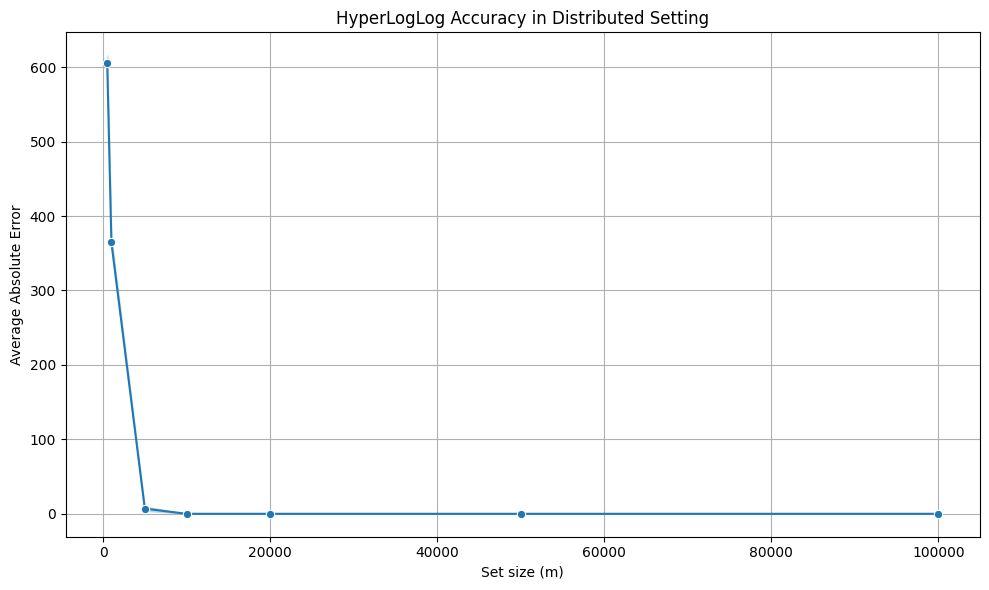

In [48]:

# Plotting function for distributed mode
def plot_distributed_only(df, y="abs_error", ylabel="Average Absolute Error"):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="m", y=y, marker="o", errorbar="sd")
    plt.title("HyperLogLog Accuracy in Distributed Setting")
    plt.xlabel("Set size (m)")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call plot
plot_distributed_only(df_dist)

### k constant m constant

In [33]:
# Parameters
k = 32  # Number of HLL centers
precision = 0.01
num_trials = 10
m = 10000 # set size
p_values = [100, 500, 1000, 2000, 5000, 10000] # Total unique elements

# Random string generator
def random_string(length=30):
    return ''.join(random.choices(string.ascii_letters, k=length))

In [34]:
# # Experiment settings
# m = 10000
# k_values = [1, 2, 4, 8, 16, 32, 64]
# num_trials = 1
# precision = 0.01

# # Random string generator
# def random_string(length=30):
#     return ''.join(random.choices(string.ascii_letters, k=length))

In [35]:
# Run experiment
results_p = []

for p in p_values:
    pool = [random_string() for _ in range(p)]  # or any base size
    for _ in range(num_trials):
        items = random.choices(pool, k=m)
        # Create k centers
        centers = [hyperloglog.HyperLogLog(precision) for _ in range(k)]

        # Assign items to centers
        for item in items:
            centers[random.randint(0, k - 1)].add(item)

        # Merge estimates
        coordinator = hyperloglog.HyperLogLog(precision)
        for center in centers:
            coordinator.update(center)

        est = len(coordinator)
        abs_error = abs(est - p)

        results_p.append({
            "p": p,
            "abs_error": abs_error
        })

# Convert to DataFrame
df_p = pd.DataFrame(results_p)

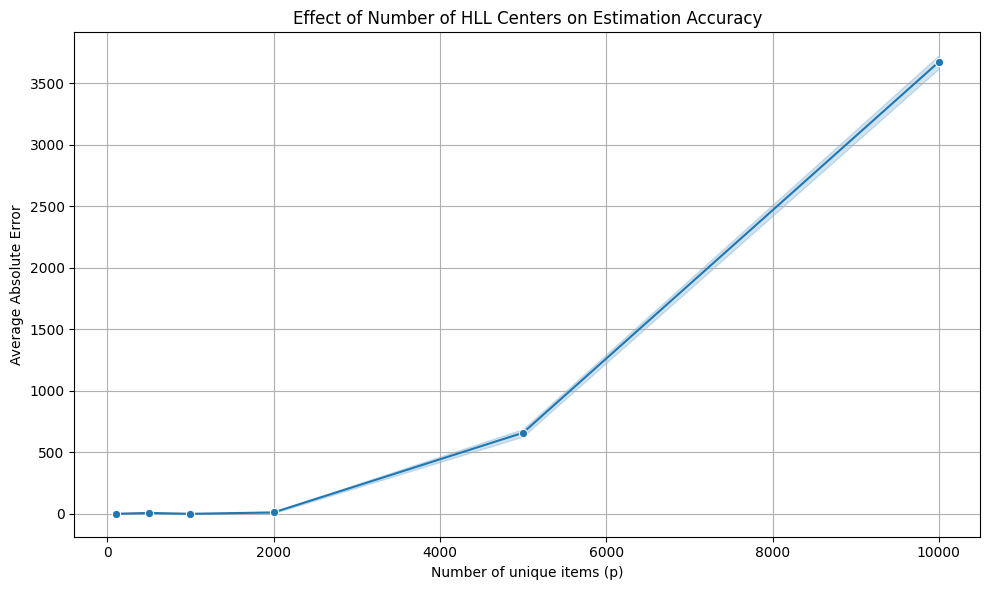

In [36]:
# Plotting function
def plot_error_vs_centers(df, y="abs_error", ylabel="Average Absolute Error"):
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=df, x="p", y=y, marker="o", errorbar="sd")
    plt.title("Effect of Number of HLL Centers on Estimation Accuracy")
    plt.xlabel("Number of unique items (p)")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call plot
plot_error_vs_centers(df_p)